# Fake News data analysis
Firstly, let's import the data.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from config import config as cfg
from config import utils

In [2]:
data_folder = utils.get_repo_path() / cfg.DATA_FOLDER
plots_folder = utils.get_repo_path() / cfg.PLOTS_FOLDER

In [3]:
news_with_text = pd.read_csv(data_folder / "fakenews_withtext.csv")
news_with_text.head()

,Unnamed: 0,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",Democratic U.S. presidential hopeful Bernie Sa...,1
1,1,Kremlin: Syria peoples' congress being 'active...,A proposal to convene a congress of all Syria ...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [4]:
news_with_text.drop(columns="Unnamed: 0", inplace=True)
news_with_text.head()

,title,text,label
0,"Sanders back in U.S. Senate, blasts 'coloniali...",Democratic U.S. presidential hopeful Bernie Sa...,1
1,Kremlin: Syria peoples' congress being 'active...,A proposal to convene a congress of all Syria ...,1
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [5]:
news_no_text = pd.read_csv(data_folder / "fakenews_notext.csv")
news_no_text.drop(columns="Unnamed: 0", inplace=True)
news_no_text.rename(columns={"real":"label"}, inplace=True)
news_no_text.head()

,title,source_domain,tweet_num,label
0,Kandi Burruss Explodes Over Rape Accusation on...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,www.zerchoo.com,38,1


First, let's analyze the fake news titles. Can we see which words are most commonly used?

In [6]:
titles = pd.concat([news_with_text[['title','label']], news_no_text[['title','label']]], ignore_index=True)
print(len(titles))
titles = titles.drop_duplicates(subset='title', keep='first')
print(len(titles))
fake_titles = list(titles[titles['label'] == 0]['title'])
fake_titles[:4]

64233
62761


[' Oregon Cop Convicted Of Shattering Biker’s Collarbone With Kick Forgot Dashcam Was On (VIDEO)',
 ' Twitter Erupts With Glee Over #CruzSexScandal Rumors (TWEETS)',
 'MUST WATCH VIDEO: Obama Tries To Trash Trump But Turns Into A Babbling Mess [Video]',
 ' AL Cops Kill Suicidal Woman After Her Parents Call For Help (VIDEO)']

Let's create a list of ALL used words in titles. Let's filter it so that a token is only counted as a word if it has at least three letters, so we get rid of most prepositions, pronouns etc.

In [7]:
all_words = []
for title in fake_titles:
    for word in title.split(" "):
        if word != " " and word: # don't add empty spaces or empty strings
            all_words.append(word)
all_words = list(filter(lambda x: len(x)>=3, all_words))
len(all_words)

292794

In [8]:
from collections import Counter
c = Counter(all_words)
c.most_common(20)

[('Trump', 5428),
 ('The', 4149),
 ('For', 3457),
 ('(VIDEO)', 2630),
 ('And', 2050),
 ('With', 2024),
 ('[Video]', 1896),
 ('and', 1571),
 ('His', 1491),
 ('About', 1422),
 ('After', 1385),
 ('[VIDEO]', 1367),
 ('the', 1318),
 ('Trump’s', 1230),
 ('Just', 1201),
 ('WATCH:', 1045),
 ('From', 921),
 ('Obama', 914),
 ('Her', 897),
 ('Over', 896)]

We can see a big problem. Words like "Trump" and "Trump's" are treated differently, even though they basically mean the same thing. There are also problems if the word ends or begins in a special symbol, like $\textit{)}$. Let's normalize the words so that the problem is fixed.

In [9]:
import re

def normalize_word(word):
    word = word.lower()
    word = re.sub(r"^[^\w]+|[^\w]+$", '', word)
    word = re.sub(r"(\'s|’s)$", '', word)
    return word

def merge_similar_words(counter):
    normalized_counter = Counter()
    for word, count in counter.items():
        normalized_word = normalize_word(word)
        normalized_counter[normalized_word] += count
    return normalized_counter

In [10]:
c = merge_similar_words(c)
c.most_common(20)

[('trump', 7963),
 ('video', 6495),
 ('the', 6259),
 ('for', 4431),
 ('and', 3919),
 ('with', 2609),
 ('obama', 1806),
 ('about', 1640),
 ('his', 1626),
 ('watch', 1624),
 ('hillary', 1610),
 ('after', 1559),
 ('just', 1392),
 ('from', 1183),
 ('her', 1127),
 ('this', 1123),
 ('over', 1043),
 ('not', 1041),
 ('are', 1039),
 ('out', 1002)]

We can obviously see that there are lots of words that are simply the most commonly used 3+ letter words in English and lots of prepositions and pronouns. However, we can easily just skip them manually and create a list of top 10 most commonly used words in the fake news titles. 

In [11]:
c.most_common(50)

[('trump', 7963),
 ('video', 6495),
 ('the', 6259),
 ('for', 4431),
 ('and', 3919),
 ('with', 2609),
 ('obama', 1806),
 ('about', 1640),
 ('his', 1626),
 ('watch', 1624),
 ('hillary', 1610),
 ('after', 1559),
 ('just', 1392),
 ('from', 1183),
 ('her', 1127),
 ('this', 1123),
 ('over', 1043),
 ('not', 1041),
 ('are', 1039),
 ('out', 1002),
 ('that', 990),
 ('clinton', 950),
 ('new', 932),
 ('donald', 892),
 ('who', 881),
 ('will', 865),
 ('you', 864),
 ('president', 851),
 ('him', 821),
 ('news', 794),
 ('why', 772),
 ('gop', 760),
 ('has', 741),
 ('was', 739),
 ('white', 706),
 ('how', 701),
 ('what', 679),
 ('breaking', 674),
 ('black', 671),
 ('she', 650),
 ('it', 624),
 ('have', 618),
 ('says', 564),
 ('tweets', 561),
 ('their', 559),
 ('one', 539),
 ('gets', 537),
 ('down', 529),
 ('america', 494),
 ('media', 476)]

In [12]:
top10 = {"Trump": 7963, "VIDEO": 6495, "Obama": 1806, "WATCH": 1624, 
         "Hillary": 1610, "just": 1392, "over": 1043, "Clinton": 950, 
         "new": 932, "Donald": 892}

The reason for why words like *just*, *over* and *new* were kept is because those are commonly used for exaggerations.

Examples: 
- "OVER $500,000 stolen from taxpayers!"
- "JUST NOW: Trump signed a controversial order" 
- "The NEW law can cost you millions"

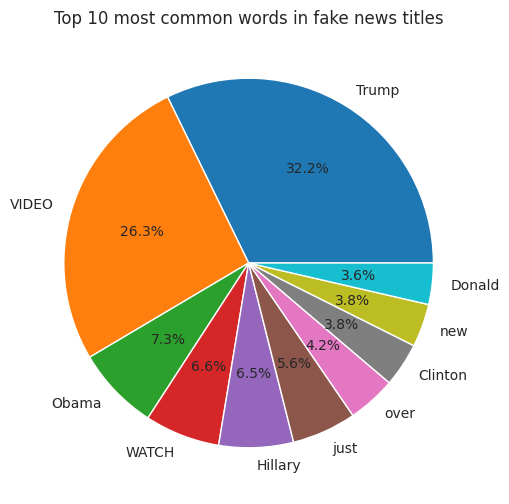

In [23]:
labels = []
sizes = []
for x, y in top10.items():
    labels.append(x)
    sizes.append(y)
sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Top 10 most common words in fake news titles')
plt.savefig(plots_folder / "titles_piechart.png")
plt.show()

**Note: the percentages are referring to the top 10 list, not the whole usage.**

Most commonly used words are:
- politicans' names, mainly the presidents or presidential candidates
- words that urge you to click on the title ("WATCH" or "[VIDEO]")
- exaggerating words, as shown before.
  
Let's now switch our focus to the news contents and try doing the same analysis.

In [14]:
fake_text = list(news_with_text[news_with_text['label'] == 0]['text'])

In [15]:
fake_text[0]

'In a baffling fit of rage, an Oregon State Police officer has been convicted of ramming his car into a stopped motorcyclist then kicking the dazed man so hard in the chest that he would need a metal plate and screws to repair his shattered collarbone and ribs. What State Police Captain Rob Edwards didn t know was that his department have installed a functioning dashboard camera. It captured the entire shocking scene.The 2012 incident with a chase that the victim says he didn t know was happening. The first he learned of Edwards  presence was when the cop was running directly into the back of his motorcycle, spilling the man from his bike. The man gets up with his hands raised only to find Edwards rushing at him with his pistol held sideways, probably imitating something he saw in a movie. The biker, identified as Justin Wilkens, barely had time to say  What did I do?  before Edwards kicked him square in the chest with such force that Wilkens would later learn he broke his collarbone a

This time, let's set the minimal threshold to four letters. We are analyzing full sentences, so three letter words are more likely to happen and they won't change the actual sentiment of the text.

In [16]:
text_words = []
for title in fake_text:
    for word in title.split(" "):
        if word != " " and word: # don't add empty spaces or empty strings
            text_words.append(word)
text_words = list(filter(lambda x: len(x)>=4, text_words))
len(text_words)

5063243

In [17]:
c2 = merge_similar_words(Counter(text_words))

In [18]:
c2.most_common(50)

[('that', 127400),
 ('trump', 67709),
 ('with', 51766),
 ('this', 45886),
 ('have', 38694),
 ('they', 38674),
 ('from', 33092),
 ('about', 27411),
 ('their', 25079),
 ('said', 24605),
 ('people', 22487),
 ('what', 20714),
 ('will', 20583),
 ('president', 20277),
 ('would', 19898),
 ('been', 18939),
 ('more', 18296),
 ('just', 17906),
 ('when', 17760),
 ('were', 17113),
 ('donald', 15913),
 ('there', 15800),
 ('like', 15379),
 ('clinton', 14590),
 ('which', 14307),
 ('because', 13674),
 ('obama', 13568),
 ('after', 13509),
 ('also', 12554),
 ('even', 12164),
 ('than', 11887),
 ('them', 11852),
 ('over', 11614),
 ('only', 11010),
 ('time', 10966),
 ('into', 10885),
 ('other', 10757),
 ('hillary', 10727),
 ('news', 10682),
 ('white', 10655),
 ('being', 10152),
 ('state', 9798),
 ('image', 9793),
 ('some', 9652),
 ('campaign', 9319),
 ('should', 9314),
 ('know', 9026),
 ('these', 8861),
 ('against', 8782),
 ('going', 8655)]

Again, let's manually create the counter with the actually meaningful words:

In [19]:
top10_2 = {"Trump": 67709, "people": 22487, "president": 20277, "would": 19898, 
           "more": 18296, "just": 17906, "Donald": 15913, "Clinton": 14590, 
           "Obama": 13568, "even": 12164}

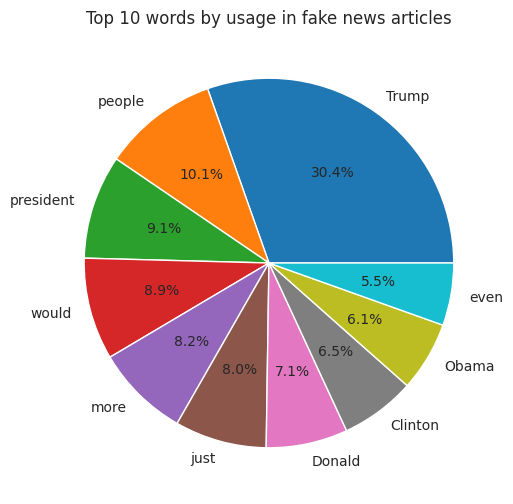

In [22]:
labels = []
sizes = []
for x, y in top10_2.items():
    labels.append(x)
    sizes.append(y)

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Top 10 words by usage in fake news articles')
plt.savefig(plots_folder / "articles_piechart.png")
plt.show()

**Note: the percentages are referring to the top 10 list, not the whole usage.**

Let's now analyze the news subjects that are most commonly the victims of fake news. We can already take a guess that politics is going to dominate the pie chart, right?

In [27]:
subjects = pd.read_csv(data_folder / "fakenews_subjects.csv")
subjects.drop(columns="Unnamed: 0", inplace=True)
subjects.head()

,subject,label
0,politicsNews,1
1,politicsNews,1
2,politicsNews,1
3,politicsNews,1
4,politicsNews,1


In [30]:
fake_subjects = list(subjects[subjects['label'] == 0]['subject'])
set(fake_subjects)

{'Government News', 'Middle-east', 'News', 'US_News', 'left-news', 'politics'}